# 利用LSGAN生成DeepFool对抗样本_picture-demo



In [1]:
import tensorflow as tf
import numpy as np
import pickle
import matplotlib.pyplot as plt

%matplotlib inline

E:\ANACONDA\envs\python374\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
E:\ANACONDA\envs\python374\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
E:\ANACONDA\envs\python374\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
E:\ANACONDA\envs\python374\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarnin

# 导入数据

In [2]:
from tensorflow.examples.tutorials.mnist import input_data

# image load
from tflearn.data_utils import image_preloader
from tflearn.data_utils import shuffle
from tflearn.data_preprocessing import ImagePreprocessing
from tflearn.data_augmentation import ImageAugmentation

train_dataset_file = './DeepFool_baleful_pngs.txt'
X,Y = image_preloader(train_dataset_file, image_shape=(9,9),mode='file',normalize=True, categorical_labels=True, grayscale=True)
X = shuffle(X)[0]

print(np.shape(X))

Instructions for updating:
non-resource variables are not supported in the long term
curses is not supported on this machine (please install/reinstall curses for an optimal experience)
(60000, 9, 9, 1)


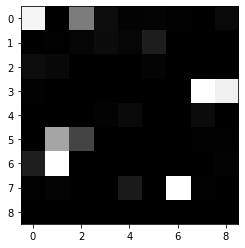

In [3]:
img = X[50]
# img = mnist.train.images[50]
plt.imshow(img.reshape((9, 9)), cmap='Greys_r')

# 构建模型

- inputs
- generator
- descriminator
- loss && optimizer

## Inputs

In [4]:
def get_inputs(real_size, noise_size):
    """
    真实图像tensor与噪声图像tensor
    """
    real_img = tf.placeholder(tf.float32, [None, real_size], name='real_img')
    noise_img = tf.placeholder(tf.float32, [None, noise_size], name='noise_img')
    
    return real_img, noise_img

## generator

In [5]:
def get_generator(noise_img, out_dim, n_units, reuse=False, alpha=0.01):
    """
    生成器
    
    noise_img: 生成器的输入
    out_dim: 生成器输出tensor的size，这里应该为9*9=81
    alpha: leaky ReLU系数
    """
    with tf.variable_scope("generator", reuse=reuse):
        # hidden layer
        hidden1 = tf.layers.dense(noise_img, n_units)
        # leaky ReLU
        hidden1 = tf.maximum(alpha * hidden1, hidden1)
       
        # logits & outputs
        logits = tf.layers.dense(hidden1, out_dim)
        outputs = tf.tanh(logits)
        
        return logits, outputs

## Discriminator

In [6]:
# image load
from tflearn.data_utils import image_preloader
from tflearn.data_preprocessing import ImagePreprocessing
from tflearn.data_augmentation import ImageAugmentation

# network build
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.normalization import local_response_normalization
from tflearn.layers.estimator import regression

# img_prep = ImagePreprocessing()
# img_prep.add_featurewise_zero_center()
# img_prep.add_featurewise_stdnorm()
# img_aug = ImageAugmentation()
    
def get_discriminator(img, n_units, reuse=False, alpha=0.01):
    """
    判别器
    
    n_units: 隐层结点数量
    alpha: Leaky ReLU系数
    """

    with tf.variable_scope("discriminator", reuse=reuse):
        
        # hidden layer
        
        hidden1 = tf.layers.dense(img, n_units)
        hidden1 = tf.maximum(alpha * hidden1, hidden1)
        # Building convolutional network
    
        logits = tf.layers.dense(hidden1, 1)
        
        outputs = tf.sigmoid(logits)
           
        return logits, outputs

## 定义参数

In [7]:
# 定义参数
# 真实图像的size
# img_size = mnist.train.images[0].shape[0]
img_size = pow(X[0].shape[0],2)

# 传入给generator的噪声size
noise_size = 10

# 生成器隐层参数
g_units = 128

# 判别器隐层参数
d_units = 64

# leaky ReLU的参数
alpha = 0.01

# learning_rate
learning_rate = 0.001
# label smoothing
smooth = 0.1

## 构建网络

In [8]:
tf.reset_default_graph()

real_img, noise_img = get_inputs(img_size, noise_size)

# generator
g_logits, g_outputs = get_generator(noise_img, img_size, g_units)

# discriminator
d_logits_real, d_outputs_real = get_discriminator(real_img, d_units)
d_logits_fake, d_outputs_fake = get_discriminator(g_outputs, d_units, reuse=True)




Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


## Loss

这里简单说一下Loss的计算方式，由于我们上面构建了两个神经网络：generator和discriminator，因此需要分别计算loss。

- discriminator
discriminator的目的在于对于给定的真图片，识别为真（1），对于generator生成的图片，识别为假（0），因此它的loss包含了真实图片的loss和生成器图片的loss两部分。

- generator
generator的目的在于让discriminator识别不出它的图片是假的，如果用1代表真，0代表假，那么generator生成的图片经过discriminator后要输出为1，因为generator想要骗过discriminator。

In [9]:
d_loss = 0.5*tf.reduce_mean(tf.pow(d_logits_real-1,2)) + 0.5*tf.reduce_mean(tf.pow(d_logits_fake,2))
g_loss = 0.5*tf.reduce_mean(tf.pow(d_logits_fake-1,2))

## Optimizer

由于我们在GAN里面一共训练了两个网络，所以需要分别定义优化函数。

In [10]:
train_vars = tf.trainable_variables()

# generator中的tensor
g_vars = [var for var in train_vars if var.name.startswith("generator")]
# discriminator中的tensor
d_vars = [var for var in train_vars if var.name.startswith("discriminator")]

# optimizer
d_train_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars)
g_train_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


# 训练

In [11]:
# batch_size
batch_size = 64
# 训练迭代轮数
epochs = 120
# 抽取样本数
n_sample = 25
# 存储测试样例
samples = []
# 存储loss
losses = []
# 保存生成器变量
saver = tf.train.Saver(var_list = g_vars)

# 开始训练
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for e in range(epochs):
        for batch_i in range(len(X)//batch_size):
            batch = np.array(X[batch_i * batch_size: (batch_i + 1) * batch_size])
            
            batch_images = batch.reshape((batch_size, 81))
            
            # 对图像像素进行scale，这是因为tanh输出的结果介于(-1,1),real和fake图片共享discriminator的参数
            batch_images = batch_images*2 - 1
            
            # generator的输入噪声
            batch_noise = np.random.uniform(-1, 1, size=(batch_size, noise_size))
            
            # Run optimizers
            _ = sess.run(d_train_opt, feed_dict={real_img: batch_images, noise_img: batch_noise})
            _ = sess.run(g_train_opt, feed_dict={noise_img: batch_noise})
        
        # 每一轮结束计算loss
        train_loss_d = sess.run(d_loss, 
                                feed_dict = {real_img: batch_images, 
                                             noise_img: batch_noise})
        
        # generator loss
        train_loss_g = sess.run(g_loss, 
                                feed_dict = {noise_img: batch_noise})
        
            
        print("Epoch {}/{}...".format(e+1, epochs),
              "Discriminator Loss: {:.4f}...".format(train_loss_d),
              "Generator Loss: {:.4f}".format(train_loss_g))    
        
        # 记录各类loss值
        losses.append((train_loss_d, train_loss_g))
        
        # 抽取样本后期进行观察
        sample_noise = np.random.uniform(-1, 1, size=(n_sample, noise_size))
        gen_samples = sess.run(get_generator(noise_img,img_size, g_units, reuse=True),
                               feed_dict={noise_img: sample_noise})
        samples.append(gen_samples)
        
        # 存储checkpoints
        saver.save(sess, './lsgan_DeepFool_ckpt/generator.ckpt')

# 将sample的生成数据记录下来
with open('./lsgan_DeepFool_ckpt/train_samples.pkl', 'wb') as f:
    pickle.dump(samples, f)



Epoch 1/120... Discriminator Loss: 0.0396... Generator Loss: 0.3408
Epoch 2/120... Discriminator Loss: 0.1482... Generator Loss: 0.2519
Epoch 3/120... Discriminator Loss: 0.1079... Generator Loss: 0.2580
Epoch 4/120... Discriminator Loss: 0.1862... Generator Loss: 0.2647
Epoch 5/120... Discriminator Loss: 0.1193... Generator Loss: 0.2341
Epoch 6/120... Discriminator Loss: 0.1823... Generator Loss: 0.2227
Epoch 7/120... Discriminator Loss: 0.1494... Generator Loss: 0.2669
Epoch 8/120... Discriminator Loss: 0.1763... Generator Loss: 0.2033
Epoch 9/120... Discriminator Loss: 0.3563... Generator Loss: 0.1006
Epoch 10/120... Discriminator Loss: 0.2197... Generator Loss: 0.1536
Epoch 11/120... Discriminator Loss: 0.1791... Generator Loss: 0.1858
Epoch 12/120... Discriminator Loss: 0.2221... Generator Loss: 0.2108
Epoch 13/120... Discriminator Loss: 0.1670... Generator Loss: 0.1959
Epoch 14/120... Discriminator Loss: 0.2902... Generator Loss: 0.1156
Epoch 15/120... Discriminator Loss: 0.118

Epoch 115/120... Discriminator Loss: 0.1837... Generator Loss: 0.1929
Epoch 116/120... Discriminator Loss: 0.1907... Generator Loss: 0.1990
Epoch 117/120... Discriminator Loss: 0.2309... Generator Loss: 0.1631
Epoch 118/120... Discriminator Loss: 0.2339... Generator Loss: 0.1677
Epoch 119/120... Discriminator Loss: 0.2044... Generator Loss: 0.1507
Epoch 120/120... Discriminator Loss: 0.2190... Generator Loss: 0.1568


# 绘制loss曲线

E:\ANACONDA\envs\python374\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


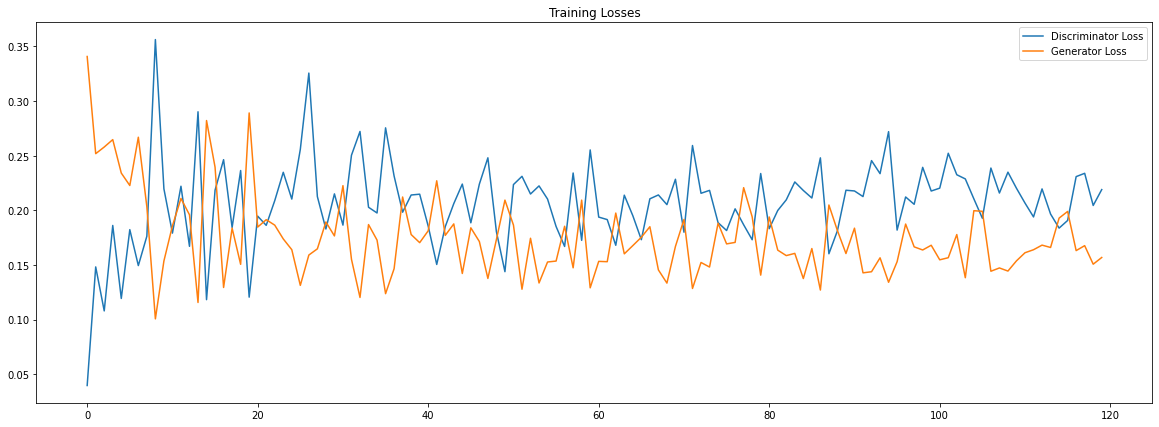

In [12]:
from Gan_tools import view_samples, view_process, adv_sample_legalization, loss_chart

loss_chart(losses)

# 显示图像

In [13]:
# Load samples from generator taken while training
with open('./lsgan_DeepFool_ckpt/train_samples.pkl', 'rb') as f:
    samples = pickle.load(f)

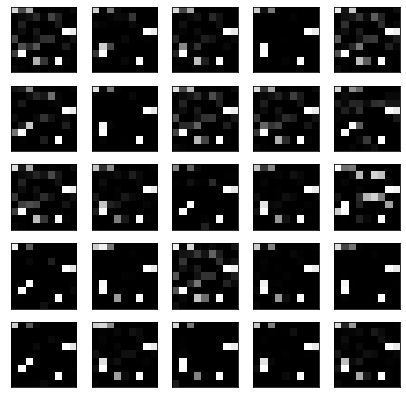

In [14]:
view_samples(samples, -1) # 显示最后一轮的outputs

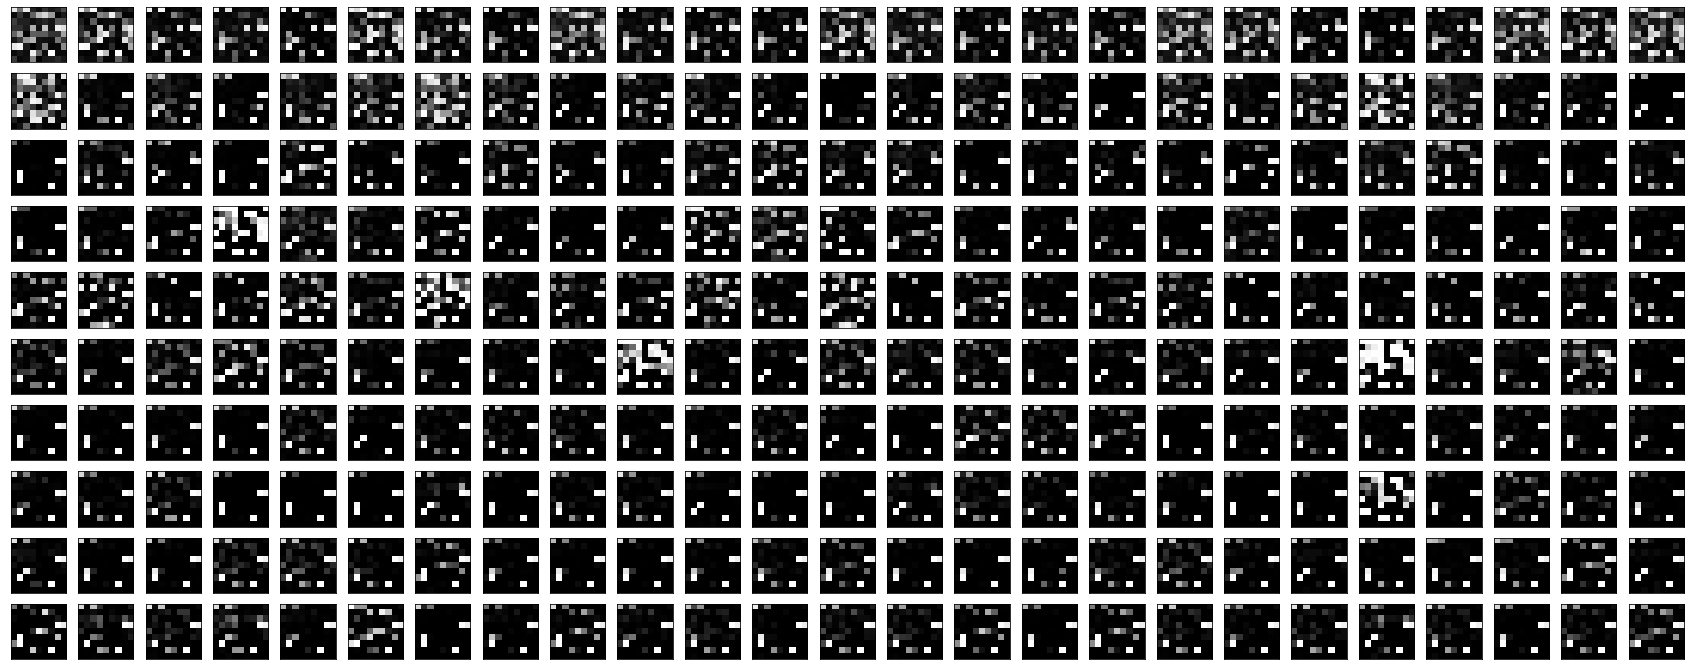

In [15]:
view_process(samples, 120)  # 显示整个生成过程图片

# 生成新的图片

In [16]:
# 加载我们的生成器变量
saver = tf.train.Saver(var_list=g_vars)
# print(g_vars)
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('lsgan_DeepFool_ckpt'))
    sample_noise = np.random.uniform(-1, 1, size=(25, 10))
    # print(sample_noise)
    gen_samples = sess.run(get_generator(noise_img, img_size, g_units, reuse=True),
                           feed_dict={noise_img: sample_noise})
    
print(np.shape(gen_samples)) # (2, 25, 81)
# 第一个下标固定为1，代表选的是outputs，而不是logits；第二个下标范围为0-24，代表选择25个样本中的一个
test = gen_samples[1][0].tolist()
print(len(test))
print(test)

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from lsgan_DeepFool_ckpt\generator.ckpt
(2, 25, 81)
81
[0.9680235385894775, -0.9926971197128296, -0.34159132838249207, -0.9723477363586426, -1.0, -0.9999910593032837, -0.9999999403953552, -0.9999998211860657, -0.9963375329971313, -1.0, -0.9980772733688354, -0.9815194010734558, 0.048632849007844925, -1.0, 0.36802926659584045, -0.08353971689939499, -1.0, -0.9999997019767761, -0.9940765500068665, -0.9895731210708618, -0.9999244809150696, -0.9502019882202148, -1.0, -0.9830979108810425, -0.9968384504318237, -0.7925097346305847, -0.9969980716705322, -0.9993118643760681, -0.9989256858825684, -1.0, -0.9987371563911438, -1.0, -1.0, -1.0, 0.9998587369918823, 0.80641770362854, -0.992456316947937, -1.0, -1.0, -0.8271048069000244, 0.30523356795310974, 0.43065720796585083, 0.06244463473558426, -0.9978473782539368, -0.996109127998352, -1.0, 1.0, -0.9999975562095642, -0.999667465

In [17]:
# 将生成的对抗样本合法化
adv_sample_legalization(test)    

[[63421.88, 8385.0, 10.79, 12484070.98, 8.58, 9.39, 616.61, 13621.64, 259.33, 18.71, 72.0, 93.55, 1998.77, 34.69, 759.06, 804.8, 1116398.15, 2129288.16, 6314388.97, 185568.13, 11671212.23, 2390913.03, 1951804.99, 6205017.87, 1142591.37, 11919759.44, 1676632.89, 981642.41, 3672882.34, 1047333.12, 0.05, 0.0, 0.0, 0.0, 3046345.75, 404090.08, 46780.22, 8106.08, 14.16, 1233.69, 411.02, 866.32, 1840645.14, 0.01, 0.05, 0.0, 0.91, 0.29, 0.08, 0.0, 0.0, 0.74, 427.63, 74.4, 730.59, 3041444.03, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 8.58, 616.61, 16.59, 13621.47, 13546.17, 1909.01, 5.88, 399423.59, 95138.28, 39477.18, 166919.14, 73016.22, 4969178.51, 922674.99, 5629468.01, 4276795.1]]


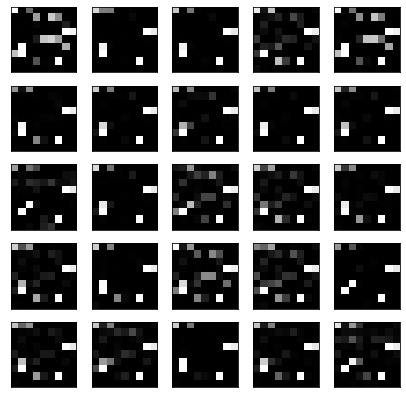

In [18]:
# 展示新生成的对抗样本图片
view_samples([gen_samples], 0)